# Predicting the NBA All-Stars with Machine Learning

The goal of this analysis is to predict the NBA All-Stars for a given year, based on All-Star selections in other years. This is accomplished by applying several machine learning classification algorithms to player performance statistics per season. The analysis is based on the [Scikit-learn](http://scikit-learn.org) machine learning package, NBA player data are taken from [basketball-reference.com](https://www.basketball-reference.com).

## Analysis initialization

In [1]:
import NBAanalysissetup # See NBAanalysissetup.py

import matplotlib.pyplot as plt
import numpy as np
import sys

Choose the year you want to use to run some validation tests (*validation_year*) and the year you want to predict (*predicion_year*), both in range 2000-2018. The years that are not selected for validation tests and prediction are used to train the model. Additionally, choose whether you want to include advanced players statistics (e.g. *PER*, *VORP*, etc.) in the model or not.

In [2]:
validation_year = 2017      # Enter any year from 2000 until 2018
prediction_year = 2018      # Enter any year from 2000 until 2018
    
includeadvancedstats = True # Enter True or False

training_years = list(range(2000, 2019))

training_years.remove(validation_year)
training_years.remove(prediction_year)
    
first_training_year = training_years[0]
last_training_year  = training_years[-1]
    
print("--> Validation_year = {}".format(validation_year))
print("--> Prediction_year = {}".format(prediction_year))
if (first_training_year < validation_year < last_training_year) and (first_training_year < prediction_year < last_training_year):
    print("--> Training years  = {}-{} except {} and {}".format(first_training_year, last_training_year, validation_year, prediction_year))
elif (first_training_year < validation_year < last_training_year):
    print("--> Training years  = {}-{} except {}".format(first_training_year, last_training_year, validation_year))
elif (first_training_year < prediction_year < last_training_year):
    print("--> Training years  = {}-{} except {}".format(first_training_year, last_training_year, prediction_year))
else:
    print("--> Training years  = {}-{}".format(first_training_year, last_training_year))
print("")

if includeadvancedstats:
    print("--> Advanced statistics included")
else:
    print("--> Advanced statistics not included")

--> Validation_year = 2017
--> Prediction_year = 2018
--> Training years  = 2000-2016

--> Advanced statistics included


## Load NBA player data:

NBA player data from 2000-2018 from [basketball-reference.com](https://www.basketball-reference.com) have been saved as csv-files in the **data** directory using the scraper functions (*NBA_per_game_scraper*, *NBA_advanced_scraper* and *NBA_per_game_scraper*) in [NBAanalysissetup.py](NBAanalysissetup.py).

In [3]:
df_training, df_validation, df_prediction = \
NBAanalysissetup.loaddata_allyears(prediction_year, validation_year, training_years, includeadvancedstats)

--> Loading   training year 1999-2000 ...
--> Loading   training year 2000-2001 ...
--> Loading   training year 2001-2002 ...
--> Loading   training year 2002-2003 ...
--> Loading   training year 2003-2004 ...
--> Loading   training year 2004-2005 ...
--> Loading   training year 2005-2006 ...
--> Loading   training year 2006-2007 ...
--> Loading   training year 2007-2008 ...
--> Loading   training year 2008-2009 ...
--> Loading   training year 2009-2010 ...
--> Loading   training year 2010-2011 ...
--> Loading   training year 2011-2012 ...
--> Loading   training year 2012-2013 ...
--> Loading   training year 2013-2014 ...
--> Loading   training year 2014-2015 ...
--> Loading   training year 2015-2016 ...
--> Loading validation year 2016-2017 ...
--> Loading prediction year 2017-2018 ...


Prepare data and create features (*X*) and target (*y*) dataframes needed for sklearn routines:

In [4]:
df_training   = df_training.  dropna() # Remove players which have NAN(s)
df_validation = df_validation.dropna() # Remove players which have NAN(s)
df_prediction = df_prediction.dropna() # Remove players which have NAN(s)

# Remove AS feature (binary variable indicating All-Star selection) since this is what we want to predict
# Remove YEAR feature since this is only used for the cross-validation scheme
# Remove features which do not have predictive power (e.g. Player name, Team name, etc.) 
# Remove features which are correlated with other features (e.g. FGA, WS, etc.)

X_training    = df_training.  drop(['AS', 'YEAR', 'Player', 'Pos', 'Tm', 'Age',
                                    'FGA/G', '3PA/G', '2PA/G', 'FTA/G', 'TRB/G'], axis=1)
X_validation  = df_validation.drop(['AS', 'YEAR', 'Player', 'Pos', 'Tm', 'Age',
                                    'FGA/G', '3PA/G', '2PA/G', 'FTA/G', 'TRB/G'], axis=1)
X_prediction  = df_prediction.drop(['AS', 'YEAR', 'Player', 'Pos', 'Tm', 'Age',
                                    'FGA/G', '3PA/G', '2PA/G', 'FTA/G', 'TRB/G'], axis=1)

if includeadvancedstats:
    X_training    = X_training.  drop(['WS'], axis=1)
    X_validation  = X_validation.drop(['WS'], axis=1)
    X_prediction  = X_prediction.drop(['WS'], axis=1)
        
y_training    = df_training  ['AS'] # The target is the AS feature
y_validation  = df_validation['AS'] # The target is the AS feature
y_prediction  = df_prediction['AS'] # The target is the AS feature

print("--> Training   data set      : # of players = {}, # of features = {}".format(X_training.shape[0], X_training.shape[1]))
print("--> Validation data set {} : # of players = {:4}, # of features = {}".format(validation_year, X_validation.shape[0], X_validation.shape[1]))
print("--> Prediction data set {} : # of players = {:4}, # of features = {}".format(prediction_year, X_prediction.shape[0], X_prediction.shape[1]))
print("")

print("--> Model features : ", list(X_training.columns))

--> Training   data set      : # of players = 6302, # of features = 39
--> Validation data set 2017 : # of players =  439, # of features = 39
--> Prediction data set 2018 : # of players =  446, # of features = 39

--> Model features :  ['G', 'GS', 'MP/G', 'FG/G', 'FG%', '3P/G', '3P%', '2P/G', '2P%', 'eFG%', 'FT/G', 'FT%', 'ORB/G', 'DRB/G', 'AST/G', 'STL/G', 'BLK/G', 'TOV/G', 'PF/G', 'PTS/G', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']


## Select ML classifier, set hyper-parameters and instantiate model:

Choose one of the 12 classifiers in the list below:

In [5]:
classifier = 1

if (classifier == 1):
    from sklearn import linear_model
    C = 0.4  # smaller value for C results in more regularization (in case you have noisy observations)
    p = 'l2' # penalty="l1" enables Lasso regularization, penalty="l2" enables Ridge regularization. Ridge gives Shrinkage (i.e. non-sparse coefficients), Lasso gives Sparsity (i.e. prefer simpler models)
    model = linear_model.LogisticRegression(C=C, penalty=p)
    modelname = 'Logistic Regression Classifier'
elif (classifier == 2):
    from sklearn.naive_bayes import GaussianNB
    model = GaussianNB()
    modelname = 'Gaussian Naive Bayes Classifier'
elif (classifier == 3):
    from sklearn.gaussian_process import GaussianProcessClassifier
    model = GaussianProcessClassifier() #(1.0 * RBF(1.0))
    modelname = 'Gaussian Process Classifier'
elif (classifier == 4):
    from sklearn.neighbors import KNeighborsClassifier
    n = 10
    model = KNeighborsClassifier(n_neighbors=n)
    modelname = 'Nearest Neighbours Classifier'
elif (classifier == 5):
    from sklearn.svm import LinearSVC                
    #from sklearn.svm import SVC                
    C = 0.05 # See Logistic Regression
    p = 'l2' # See Logistic Regression
    model = LinearSVC(C=C, penalty=p, dual=False)
    #model = SVC(kernel='linear', C=C, class_weight='balanced') #(gamma=2)
    modelname = 'Linear Support Vector Machine Classifier'
elif (classifier == 6):
    from sklearn.tree import DecisionTreeClassifier
    m = None
    model = DecisionTreeClassifier(max_depth=m)
    modelname = 'Decision Tree Classifier'
elif (classifier == 7):
    from sklearn.ensemble import RandomForestClassifier
    m = None
    n = 100
    f = 'auto'
    model = RandomForestClassifier(n_estimators=n, max_depth=m, max_features=f) #, class_weight='balanced'
    modelname = 'Random Forest Classifier'
elif (classifier == 8):
    from sklearn.ensemble import ExtraTreesClassifier
    m = None
    n = 100
    model = ExtraTreesClassifier(max_depth=m, n_estimators=n, min_samples_split=2, random_state=0)
    modelname = 'Extra Trees Classifier'
elif (classifier == 9):
    from sklearn.ensemble import GradientBoostingClassifier
    n = 100
    m = None
    l = 0.1
    model = GradientBoostingClassifier(n_estimators=n, max_depth=m, learning_rate=l)
    modelname = 'Gradient Tree Boosting Classifier'
elif (classifier == 10):
    from sklearn.ensemble import AdaBoostClassifier
    n = 100
    l = 0.1
    model = AdaBoostClassifier(n_estimators=n, learning_rate=l)
    modelname = 'Ada Boost Classifier'
elif (classifier == 11):
    from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
    model = QuadraticDiscriminantAnalysis()
    modelname = 'Quadratic Discriminant Analysis Classifier'
elif (classifier == 12):
    from sklearn.neural_network import MLPClassifier
    a = 1
    model = MLPClassifier(alpha=a)
    modelname = 'Neural Network Classifier'
else:
    print("That number does not correspond to an implemented classifier - EXIT")
    
print("--> Selected classifier =", modelname)

--> Selected classifier = Logistic Regression Classifier


## Cross-validation

Cross-validate the model using training data and the *LeaveOneGroupOut* cross-validation scheme, and calculate some model scores:

In [6]:
from sklearn.model_selection import cross_validate, LeaveOneGroupOut

logo = LeaveOneGroupOut()

cv_groups = df_training['YEAR'] # Use YEAR to define groups in LeaveOneGroupOut cross-validation scheme

cv_logo = logo.split(X_training, y_training, groups=cv_groups)

scoring_list = ['precision', 'recall', 'f1', 'accuracy', 'roc_auc']

scores = cross_validate(model, X_training, y_training, cv=cv_logo, scoring=scoring_list, n_jobs=-1)

print("--> Cross-val years  :", ["{:5d}".format(yr) for yr in training_years])
print("")
print("--> Precision scores :", ["{:5.2f}".format(i) for i in scores['test_precision']])
print("--> Recall    scores :", ["{:5.2f}".format(i) for i in scores['test_recall'   ]])
print("--> F1        scores :", ["{:5.2f}".format(i) for i in scores['test_f1'       ]])
print("--> Accuracy  scores :", ["{:5.2f}".format(i) for i in scores['test_accuracy' ]])
print("--> ROC-AUC   scores :", ["{:5.2f}".format(i) for i in scores['test_roc_auc'  ]])
print("")
print("--> Precision score : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_precision']), np.std(scores['test_precision'])))
print("--> Recall score    : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_recall'   ]), np.std(scores['test_recall'   ])))
print("--> F1 score        : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_f1'       ]), np.std(scores['test_f1'       ])))
print("--> Accuracy score  : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_accuracy' ]), np.std(scores['test_accuracy' ])))
print("--> ROC-AUC score   : {:5.1%} +/- {:5.1%}".format(np.mean(scores['test_roc_auc'  ]), np.std(scores['test_roc_auc'  ])))

--> Cross-val years  : [' 2000', ' 2001', ' 2002', ' 2003', ' 2004', ' 2005', ' 2006', ' 2007', ' 2008', ' 2009', ' 2010', ' 2011', ' 2012', ' 2013', ' 2014', ' 2015', ' 2016']

--> Precision scores : [' 0.89', ' 0.59', ' 0.77', ' 1.00', ' 0.81', ' 0.78', ' 0.79', ' 0.77', ' 0.73', ' 0.80', ' 0.86', ' 0.81', ' 0.76', ' 0.74', ' 0.70', ' 0.90', ' 0.82']
--> Recall    scores : [' 0.57', ' 0.59', ' 0.59', ' 0.74', ' 0.65', ' 0.70', ' 0.71', ' 0.71', ' 0.67', ' 0.70', ' 0.67', ' 0.71', ' 0.64', ' 0.58', ' 0.64', ' 0.64', ' 0.88']
--> F1        scores : [' 0.70', ' 0.59', ' 0.67', ' 0.85', ' 0.72', ' 0.74', ' 0.75', ' 0.74', ' 0.70', ' 0.74', ' 0.75', ' 0.76', ' 0.70', ' 0.65', ' 0.67', ' 0.75', ' 0.85']
--> Accuracy  scores : [' 0.98', ' 0.96', ' 0.97', ' 0.98', ' 0.97', ' 0.97', ' 0.97', ' 0.97', ' 0.96', ' 0.97', ' 0.97', ' 0.97', ' 0.96', ' 0.96', ' 0.96', ' 0.97', ' 0.98']
--> ROC-AUC   scores : [' 0.99', ' 0.98', ' 0.99', ' 0.99', ' 0.97', ' 0.99', ' 0.99', ' 0.99', ' 0.99', ' 0.99', 

## Model training

Fit model to training data, use fitted model to predict validation data and calculate the corresponding confusion matrix and some model scores:

In [7]:
model.fit(X_training, y_training)     # Fit model to training data

y_model = model.predict(X_validation) # Predict validation data

y_valtrue  = y_validation.tolist()

from sklearn.metrics import confusion_matrix

CM = confusion_matrix(y_valtrue, y_model) # defined as: rows -> true, columns -> prediction

print("--> Confusion matrix {}:".format(validation_year))
print(CM)
print("")

TN = CM[0,0] # defined as: 0 = negative, 1 = positive
FN = CM[1,0] # defined as: 0 = negative, 1 = positive
FP = CM[0,1] # defined as: 0 = negative, 1 = positive
TP = CM[1,1] # defined as: 0 = negative, 1 = positive

TOT = TP + FP + FN + TN

print("--> TP = {}, FP = {}, FN = {}, TN = {}".format(TP, FP ,FN, TN))
print("")
print("--> True  Positive Rate i.e. Recall   (TP/(TP+FN)) = {:5.1%}".format(TP/(TP+FN)))
print("--> False Positive Rate i.e. Fall-Out (FP/(FP+TN)) = {:5.1%}".format(FP/(FP+TN)))
print("")

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

precision = precision_score(y_validation, y_model)
recall    = recall_score   (y_validation, y_model)
f1        = f1_score       (y_validation, y_model)
accuracy  = accuracy_score (y_validation, y_model)
roc_auc   = roc_auc_score  (y_validation, y_model)
        
print("--> Precision score : {:.1%}".format(precision))
print("--> Recall score    : {:.1%}".format(recall   ))
print("--> F1 score        : {:.1%}".format(f1       ))
print("--> Accuracy score  : {:.1%}".format(accuracy ))
print("--> ROC-AUC score   : {:.1%}".format(roc_auc  ))

--> Confusion matrix 2017:
[[404  10]
 [  4  21]]

--> TP = 21, FP = 10, FN = 4, TN = 404

--> True  Positive Rate i.e. Recall   (TP/(TP+FN)) = 84.0%
--> False Positive Rate i.e. Fall-Out (FP/(FP+TN)) =  2.4%

--> Precision score : 67.7%
--> Recall score    : 84.0%
--> F1 score        : 75.0%
--> Accuracy score  : 96.8%
--> ROC-AUC score   : 90.8%


 Calculate ROC and PR curves using validation data:

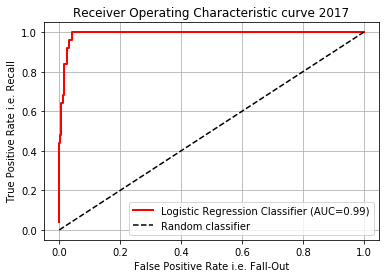

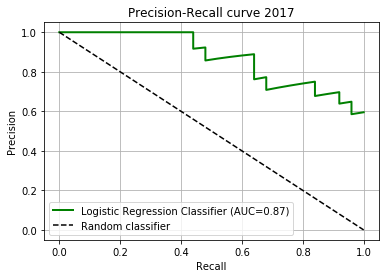

In [8]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

decisionfunctionclassifiers = [1, 5] # LogisticRegression, SVC

if (classifier in decisionfunctionclassifiers):
    y_score = model.decision_function(X_validation)
else:
    y_score = model.predict_proba(X_validation)

if (classifier in decisionfunctionclassifiers):
    fpr, tpr, thresholds = roc_curve(y_validation, y_score)       # to be used when y_score is calculated using decision_function method
else:
    fpr, tpr, thresholds = roc_curve(y_validation, y_score[:, 1]) # to be used when y_score is calculated using predict_proba method

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='{} (AUC={:.2f})'.format(modelname, roc_auc))
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate i.e. Fall-Out')
plt.ylabel('True Positive Rate i.e. Recall')
plt.title('Receiver Operating Characteristic curve {}'.format(validation_year))
plt.legend(loc="lower right")
#plt.text(0.65, 0.3, r"ROC-AUC = {:.2f}".format(roc_auc), color='red')
plt.grid(True)

if (classifier in decisionfunctionclassifiers):
    precision, recall, _ = precision_recall_curve(y_validation, y_score)       # to be used when y_score is calculated using decision_function method
else:
    precision, recall, _ = precision_recall_curve(y_validation, y_score[:, 1]) # to be used when y_score is calculated using predict_proba method

pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, color='green', lw=2, label='{} (AUC={:.2f})'.format(modelname, pr_auc))
plt.plot([0, 1], [1, 0], color='black', linestyle='--', label='Random classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve {}'.format(validation_year))
plt.legend(loc="lower left")
#plt.text(0.05, 0.3, r"PR-AUC = {:.2f}".format(pr_auc), color='green')
plt.grid(True)

Calculate the feature coefficients and importances of the fitted model, if applicable:

In [9]:
if hasattr(model, "coef_"):
    print("--> Model coefficients: ")  #, model.coef_.ravel())
    print("")
    for name, coef in zip(X_training.columns, model.coef_.ravel()):
        print("----> Model coefficient {:5} = {:>6.3f}".format(name, coef))
    
if hasattr(model, "feature_importances_"):
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    print("--> Feature importances: ") #, model.feature_importances_.ravel())
    print("")
    
    for i in range(X_training.shape[1]):
        print("----> Feature importance ({:>2}) {:5} : {:.3f}".format(i + 1, X_training.columns[indices[i]], importances[indices[i]]))
    #for name, imp in zip(X_training.columns, model.feature_importances_):
    #    print("----> Feature importance {:4} : {:.3f}".format(name, imp))

--> Model coefficients: 

----> Model coefficient G     = -0.273
----> Model coefficient GS    =  0.217
----> Model coefficient MP/G  = -0.214
----> Model coefficient FG/G  =  0.131
----> Model coefficient FG%   = -0.255
----> Model coefficient 3P/G  =  0.075
----> Model coefficient 3P%   =  0.271
----> Model coefficient 2P/G  =  0.041
----> Model coefficient 2P%   = -0.348
----> Model coefficient eFG%  = -0.280
----> Model coefficient FT/G  = -0.088
----> Model coefficient FT%   = -0.196
----> Model coefficient ORB/G =  0.279
----> Model coefficient DRB/G =  0.661
----> Model coefficient AST/G =  0.765
----> Model coefficient STL/G = -0.267
----> Model coefficient BLK/G =  0.048
----> Model coefficient TOV/G =  0.502
----> Model coefficient PF/G  = -0.849
----> Model coefficient PTS/G =  0.229
----> Model coefficient PER   = -0.084
----> Model coefficient TS%   = -0.284
----> Model coefficient 3PAr  = -0.341
----> Model coefficient FTr   = -0.142
----> Model coefficient ORB%  = -0.301

## Model predictions

Use fitted model to predict the NBA All-Stars in *prediction_year*, and calculate the corresponding confusion matrix:

--> Confusion matrix 2018:
[[414   4]
 [  5  23]]

--> TP = 23, FP = 4, FN = 5, TN = 414

--> Precision (TP/(TP+FP)) = 85.2% (Answers the question: Out of all true All-Stars, how many are predicted?)
--> Recall    (TP/(TP+FN)) = 82.1% (Answers the question: Out of all predicted All-Stars, how many are true?)
--> F1 score               = 83.6% (i.e. the harmonic mean of Precision and Recall)
--> Accuracy ((TP+TN)/TOT) = 98.0% (Answers the question: Out of all players, how many are correctly predicted?)


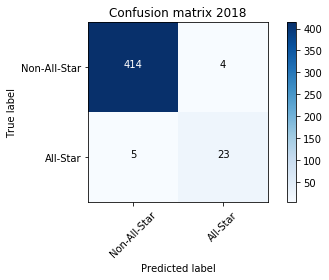

In [10]:
y_model = model.predict(X_prediction) # Use fitted model on prediction data

y_true  = y_prediction.tolist()

CM = confusion_matrix(y_true, y_model) # defined as: rows -> true, columns -> prediction

print("--> Confusion matrix {}:".format(prediction_year))
print(CM)
print("")

TN = CM[0,0] # defined as: 0 = negative, 1 = positive
FN = CM[1,0] # defined as: 0 = negative, 1 = positive
FP = CM[0,1] # defined as: 0 = negative, 1 = positive
TP = CM[1,1] # defined as: 0 = negative, 1 = positive

TOT = TP + FP + FN + TN

print("--> TP = {}, FP = {}, FN = {}, TN = {}".format(TP, FP ,FN, TN))
print("")

note1 = " (Answers the question: Out of all true All-Stars, how many are predicted?)"
note2 = " (Answers the question: Out of all predicted All-Stars, how many are true?)"
note3 = " (i.e. the harmonic mean of Precision and Recall)"
note4 = " (Answers the question: Out of all players, how many are correctly predicted?)"
    
print("--> Precision (TP/(TP+FP)) = {:5.1%}".format(TP/(TP+FP))         + note1)
print("--> Recall    (TP/(TP+FN)) = {:5.1%}".format(TP/(TP+FN))         + note2)
print("--> F1 score               = {:5.1%}".format(2*TP/(2*TP+FP+FN))  + note3)
print("--> Accuracy ((TP+TN)/TOT) = {:5.1%}".format((TP+TN)/TOT)        + note4) 
    
np.set_printoptions(precision=2)
class_names = ['Non-All-Star','All-Star']

plt.figure()
NBAanalysissetup.plot_confusion_matrix(CM, classes=class_names,
                                       title='Confusion matrix {}'.format(prediction_year))

#plt.figure()
#NBAanalysissetup.plot_confusion_matrix(CM, classes=class_names, normalize=True,
#                                       title='Normalized confusion matrix')   

Print classification report:

In [11]:
print("--> Classification report {}:".format(prediction_year))
print("")

from sklearn.metrics import classification_report
class_names = ['Non-All-Stars (true)', 'All-Stars (true)']
print(classification_report(y_true, y_model, target_names=class_names))

--> Classification report 2018:

                      precision    recall  f1-score   support

Non-All-Stars (true)       0.99      0.99      0.99       418
    All-Stars (true)       0.85      0.82      0.84        28

         avg / total       0.98      0.98      0.98       446



Check which players are All-Stars according to the model:

In [12]:
counts = [0, 0, 0, 0]

snubbed      = []
deserved     = []
questionable = []
    
for i in range(0, len(y_model)):
    if ((y_true[i] == 0) and (y_model[i] == 0)):    # TN
        counts[0] += 1
    elif ((y_true[i] == 0) and (y_model[i] == 1)):  # FP
        counts[1] += 1
        snubbed.append(df_prediction.iat[i,0])              # 0-th column in df is player name
    elif ((y_true[i] == 1) and (y_model[i] == 0)):  # FN
        counts[2] += 1
        questionable.append(df_prediction.iat[i,0])         # 0-th column in df is player name
    else:                                           # TP
        counts[3] += 1
        deserved.append(df_prediction.iat[i,0])             # 0-th column in df is player name
        
print("--> # of     All-Stars predicted to be     All-Stars = {:>3} (TP)".format(counts[3]))
print("--> # of     All-Stars predicted to be non-All-Stars = {:>3} (FN)".format(counts[2]))
print("--> # of non-All-Stars predicted to be     All-Stars = {:>3} (FP)".format(counts[1]))
print("--> # of non-All-Stars predicted to be non-All-Stars = {:>3} (TN)".format(counts[0]))
print("")
print("--> Deserved true All-Stars:     ", deserved)
print("")
print("--> Questionable true All-Stars: ", questionable)
print("")
print("--> Snubbed non-All-Stars:       ", snubbed)

--> # of     All-Stars predicted to be     All-Stars =  23 (TP)
--> # of     All-Stars predicted to be non-All-Stars =   5 (FN)
--> # of non-All-Stars predicted to be     All-Stars =   4 (FP)
--> # of non-All-Stars predicted to be non-All-Stars = 414 (TN)

--> Deserved true All-Stars:      ['LaMarcus Aldridge', 'Giannis Antetokounmpo', 'Bradley Beal', 'Jimmy Butler', 'DeMarcus Cousins', 'Stephen Curry', 'Anthony Davis', 'DeMar DeRozan', 'Andre Drummond', 'Kevin Durant', 'Joel Embiid', 'Paul George', 'James Harden', 'Kyrie Irving', 'LeBron James', 'Damian Lillard', 'Kyle Lowry', 'Victor Oladipo', 'Kristaps Porzingis', 'Karl-Anthony Towns', 'Kemba Walker', 'John Wall', 'Russell Westbrook']

--> Questionable true All-Stars:  ['Goran Dragic', 'Draymond Green', 'Al Horford', 'Kevin Love', 'Klay Thompson']

--> Snubbed non-All-Stars:        ['Blake Griffin', 'Nikola Jokic', 'Chris Paul', 'Ben Simmons']


List all NBA players in *prediction_year* according to their model scores:

In [13]:
print("--> Model scores for all players in {}:".format(prediction_year))
print("")


if (classifier in decisionfunctionclassifiers):
    y_score = model.decision_function(X_prediction)
else:
    y_score = model.predict_proba(X_prediction)


#y_score = model.decision_function(X_prediction)
#y_score = model.predict_proba(X_prediction)

player_score_dict = {}
player_AS_dict    = {}

if includeadvancedstats:
    AS_index = 49
else:
    AS_index = 29
    
for i in range(0, len(y_model)):
    if (classifier in decisionfunctionclassifiers):
        player_score_dict[df_prediction.iat[i,0]] = y_score[i].ravel()[0]
    else:
        player_score_dict[df_prediction.iat[i,0]] = y_score[i].ravel()[1]
    if df_prediction.iat[i,AS_index] > 0.5:
        status = 'All-Star'
    else:
        status = 'Non-All-Star'
    player_AS_dict[df_prediction.iat[i,0]] = status
        
import operator
sorted_player_score_dict = sorted(player_score_dict.items(), key=operator.itemgetter(1), reverse=True)
    
counter = 0
printed_line = False
for key, value in dict(sorted_player_score_dict).items():
    counter += 1
    if (classifier in decisionfunctionclassifiers):
        if (value < 0 and not printed_line):
            print("*******************************************")
            printed_line = True
    else:
        if (value < 0.5 and not printed_line):
            print("*******************************************")
            printed_line = True
    print("----> {:3}: {:24} = {:.3f} ({})".format(counter, key, value, player_AS_dict[key]))

--> Model scores for all players in 2018:

---->   1: James Harden             = 8.728 (All-Star)
---->   2: LeBron James             = 7.171 (All-Star)
---->   3: Anthony Davis            = 6.641 (All-Star)
---->   4: Kevin Durant             = 6.399 (All-Star)
---->   5: Russell Westbrook        = 5.613 (All-Star)
---->   6: Damian Lillard           = 5.157 (All-Star)
---->   7: Stephen Curry            = 5.000 (All-Star)
---->   8: DeMarcus Cousins         = 4.522 (All-Star)
---->   9: Giannis Antetokounmpo    = 4.389 (All-Star)
---->  10: Kyrie Irving             = 3.621 (All-Star)
---->  11: Joel Embiid              = 3.431 (All-Star)
---->  12: LaMarcus Aldridge        = 2.960 (All-Star)
---->  13: DeMar DeRozan            = 2.412 (All-Star)
---->  14: Victor Oladipo           = 1.763 (All-Star)
---->  15: Chris Paul               = 1.652 (Non-All-Star)
---->  16: Karl-Anthony Towns       = 1.502 (All-Star)
---->  17: John Wall                = 1.261 (All-Star)
---->  18: Kemba W